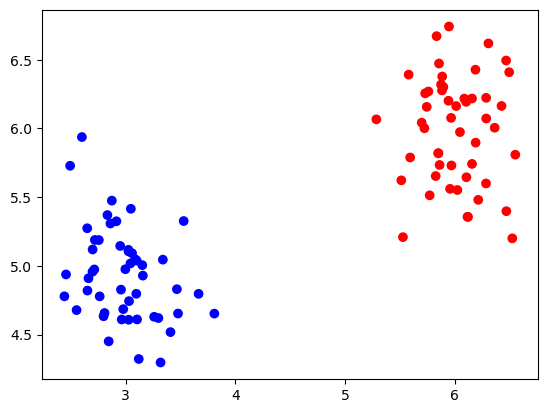

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

N1 = 50
N2 = 50
K = 2
sigma = 0.1

mean = (6, 6)
cov = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
c1 = ['red'] * len(X1)

mean = (3, 5)
cov = [[sigma, 0], [0, sigma]]
X2 = np.random.multivariate_normal(mean, cov, N2)
c2 = ['blue'] * len(X2)

X = np.concatenate((X1, X2))
color = np.concatenate((c1, c2))

T = 0 * np.ones([len(X), K])
for n in range(0, len(X)):
    if (n < len(X1)):
        T[n][0] = 1
    if (n >= N1 and n < len(X1) + len(X2)):
        T[n][1] = 1
T = T.astype(int)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=color)
plt.show()

In [2]:
def fi_classification_fun(xn, M, m, X):
    x_max = np.max(X)
    x_min = np.min(X)
    mu = np.linspace(x_min, x_max, M)
    sigma = 1
    x_1 = xn[0]
    x_2 = xn[1]
    item = - ((x_1 - mu[m]) ** 2 + (x_2 - mu[m]) ** 2) / (2 * (sigma ** 2))
    result = np.exp(item)
    return result


def sigmoid_classification_fun(w, fi_square, N):
    sigmoid_fun = np.zeros([N, 1])
    for i in range(N):
        a = np.dot(fi_square[i], w)
        item = 1 / (1 + np.exp(-a))
        sigmoid_fun[i] = item
    return sigmoid_fun


def predictive_classification(X, T, M, alpha):
    N = len(X)
    t = np.zeros([N, 1])
    for i in range(N):
        t[i] = T[i][0]

    w = np.zeros([M, 1])
    S0_1 = np.zeros([M, M])
    row, col = np.diag_indices_from(S0_1)
    S0_1[row, col] = 1 / alpha
    mm = M - 1
    fi_square = np.zeros([N, mm])
    for n in range(N):
        for m in range(mm):
            fi_square[n][m] = fi_classification_fun(X[n], mm, m, X)
    # fi_square[:, 0] = 1
    fi_square = np.concatenate((np.ones((N1 + N2, 1)), fi_square), axis=1)
    print(fi_square[:2])
    # newton
    while True:
        sig_fun = sigmoid_classification_fun(w, fi_square, N)
        R = np.zeros([N, N])
        for i in range(N):
            for j in range(N):
                if i == j:
                    R[i][j] = sig_fun[i] * (1 - sig_fun[i])

        E_l = np.dot(S0_1, w)
        dif = sig_fun - t
        E_r = np.dot(fi_square.T, dif)
        E = E_l + E_r

        H_rr = np.dot(fi_square.T, R)
        H_r = np.dot(H_rr, fi_square)
        H = S0_1 + H_r
        H_1 = np.linalg.inv(H)

        w_new = w - np.dot(H_1, E)
        if np.linalg.norm(w_new - w) < 2e-3:
            w = w_new
            return w, H_1, fi_square
        else:
            w = w_new



In [3]:
def predictive_t(w, H_1, M, x_input, X):
    # Ptn
    fi_list = np.zeros([M, 1])

    for m in range(M):
        fi_list[m][0] = fi_classification_fun(x_input, M, m, X)

    a_MAP = np.dot(w.T, fi_list)  #fi list at input x
    fi = fi_list
    sigma_ = np.dot(fi.T, H_1)
    sigma = np.dot(sigma_, fi)

    fenmu = np.sqrt(1 + (np.pi * sigma) / 8)
    a = a_MAP / fenmu

    p_t = 1 / (1 + np.exp(-a))

    return p_t

In [4]:
N = len(X)
M = 3
alpha = 0.01
p_t_t = np.zeros([N, 1])
w, H_1, fi_square = predictive_classification(X, T, M=M, alpha=alpha)
for n in range(N):
    p_t = predictive_t(w, H_1, M, X[n], X)
    p_t_t[n] = p_t
print(p_t_t[:2])
print(w)


def display(m, alpha, x, y_, x_ori, y_noise):
    fig, ax = plt.subplots()
    # line1, = ax.plot(x, y_origin, color='red', label=f'{origin_func}')
    line1, = ax.plot(x, y_, color='red')
    # ax.legend()
    # # ax.set_title('Linear and Quadratic Functions')
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')

    plt.scatter(x_ori, y_noise, marker='o', c=color)
    plt.show()


[[1.00000000e+00 2.66575751e-06 5.94548683e-01]
 [1.00000000e+00 9.87304483e-06 4.39694677e-01]]
[[0.5191555 ]
 [0.51384193]]
[[-0.00712757]
 [-0.01127512]
 [ 0.13146343]]


(100, 2) (100,)


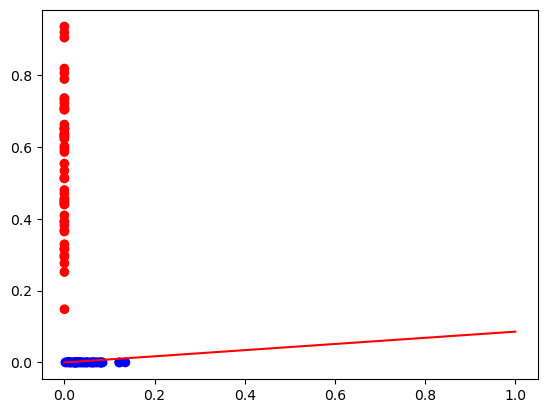

In [5]:
data = sigmoid_classification_fun(w, fi_square, N).reshape(-1)
print((X / np.max(X)).shape, data.shape)
x = np.linspace(0, 1, N)
k = -w[1] / w[2]
data = sigmoid_classification_fun(w, fi_square, N)
# print(X.shape, print(fi_square.shape))
display(M, alpha, x, x * k, fi_square[:, 1], fi_square[:, 2])
# 1 : red point
# 0 : blue point

[[1.00000000e+00 2.66575751e-06 5.94548683e-01]
 [1.00000000e+00 9.87304483e-06 4.39694677e-01]]


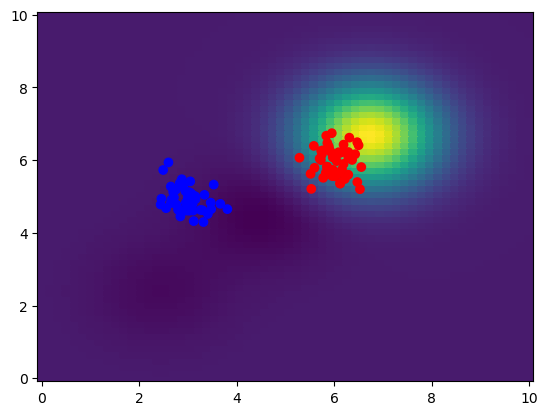

In [6]:
ix = np.linspace(0, 10, 60)
iy = np.linspace(0, 10, 60)
ic = np.zeros([60, 60])
iX, iY = np.meshgrid(ix, iy)

x_single = np.zeros([1, 2])
w, H_1, fi_square = predictive_classification(X, T, M, alpha=alpha)

for i in range(60):
    for j in range(60):
        x_single[0][0] = ix[i]
        x_single[0][1] = iy[j]
        pt_x = predictive_t(w, H_1, M, x_single[0], X)
        ic[i][j] = pt_x

plt.pcolormesh(iX, iY, ic, edgecolors='face')
plt.scatter(X[:, 0], X[:, 1], marker='o', c=color)
plt.show()



**4.Ask the user to enter any new value of x, and your task is to provide the decision whether it belongs to C1 or C2, and its uncertainty information.**

In [7]:
# 1 : red point , C1
# 0 : blue point, C2
# input x : [x1,x2]

In [8]:
# input_x1 =input()
# input_x2 =input()

In [9]:
# input_x = np.zeros([1,2])
# input_x[0][0] = input_x1
# input_x[0][1] = input_x2

In [10]:
# pt_x = predictive_t(w, H_1, 3, input_x[0],X)
# if pt_x > 0.5:
#     print('this point belong to C1, its uncertainty is {}'.format(pt_x))
# elif pt_x < 0.5:
#     print('this point belong to C2, its uncertainty is {}'.format(1 - pt_x))
# else:
#     print('can not decide')

The end at 2022.9.29 23:00